In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datajoint as dj
import pandas as pd
from pathlib import Path
import pickle
import seaborn as sns
# import logging
# log = logging.getLogger()
# log.setLevel(logging.DEBUG)

# from io_utils import *
from trials_table import * 
from performance_plots import *
%load_ext autoreload
%autoreload 2
# dj.blob.use_32bit_dims = True # necessary for pd.blob read

In [47]:
#### MULTI SESSION

animal_id = 'R502'
bdata = dj.create_virtual_module("bdata", "bdata")
subject_session_key = {"ratname": animal_id}

pd_blobs0 = (bdata.Sessions & subject_session_key).fetch(
    "protocol_data", as_dict=True
)

sess_ids0, dates0, trials0 = (bdata.Sessions & subject_session_key).fetch(
    "sessid", "sessiondate", "n_done_trials"
)

peh_blobs0 = (bdata.ParsedEvents * bdata.Sessions & subject_session_key).fetch('peh', as_dict=True)



In [49]:
dict_for_saving = {'pds':pd_blobs0, 'sess_ids': sess_ids0, 'dates' : dates0, 'trials': trials0, 'pehs' : peh_blobs0}

output = open('data/pd_peh.pkl', 'wb')
pickle.dump(dict_for_saving, output)
output.close()

In [2]:

with open('data/pd_peh.pkl', 'rb') as fh:
    pd_peh_dict = pickle.load(fh)


In [3]:
pd_blobs0 = pd_peh_dict['pds']
peh_blobs0 = pd_peh_dict['pehs']
trials0 = pd_peh_dict['trials']
sess_ids0 = pd_peh_dict['sess_ids']
dates0 = pd_peh_dict['dates']

In [4]:

trial_filter = (trials0 != 0) & (trials0 != 1)
pd_blobs1, peh_blobs1, trials1, sess_ids1, dates1 = drop_sessions(
    pd_blobs0, peh_blobs0, trials0, sess_ids0, dates0, trial_filter
)


pd_dicts0 = convert_to_dict(pd_blobs1)
reformat_pd_dict(pd_dicts0)

peh_dicts0 = convert_to_dict(peh_blobs1)

assert len(pd_dicts0) == len(peh_dicts0) == len(trials1) == len(sess_ids1) == len(dates1) , (
    "number of sessions does not match, assumptions of code below are broken!"
)

pd_dicts, peh_dicts, trials, sess_ids, dates = find_and_fix_len_errors(
    pd_dicts0, peh_dicts0, trials1, sess_ids1, dates1
)


peh_dicts_for_df = get_peh_vars_for_df(peh_dicts, trials, sess_ids)


dropping 1 sessions of 125
dropping 0 sessions of 124


In [5]:

df = generate_trials_df('R502', pd_dicts, peh_dicts_for_df, trials, sess_ids, dates)



In [13]:
def plot_single_date_trial_dur(df, date, axs):

    """
    Function to plot trial duration (measured by enter & exit times
    of state0) across trials in day.

    params
    -----
    df : data frame
        trials data frame with ['trial', 't_dur', 'date'] columns
    date : str or datetime
        date of which to plot (will convert str to datetime)
    axs : ndarray
        axes of which to plot to (must be size 2)
    
    plots
    -----
    axs[0]: trial dur vs trial number w/ mean marked in black dash
    axs[1]: trial dur vs trial w/ zoom around mean
    """

    # catch errors
    assert len(axs) == 2, "plot requires 2 axs"

    # filter for single date
    if type(date) == str:
        date = pd.Timestamp(date)
    date_df = df[(df.date == date)]
    
    # plot full line & zoomed in
    sns.lineplot(data=date_df, x="trial", y="t_dur", ax=axs[0])
    sns.lineplot(data=date_df, x="trial", y="t_dur", ax=axs[1])

    # add in mean dur for the session
    mean_dur = date_df.t_dur.mean()
    axs[0].axhline(mean_dur, color="k", linestyle="--", zorder=1, label="mean")
    axs[1].axhline(mean_dur, color="k", linestyle="--", zorder=1)
    
    # aesthetics
    axs[0].legend()
    _ = axs[0].set(ylabel=" ", title="Trial Duration Across Session" )
    _ = axs[1].set(ylabel="Trial Duration [s]", xlabel="Trial")
    axs[1].set_ylim([1,mean_dur + 5])
    plt.tight_layout()


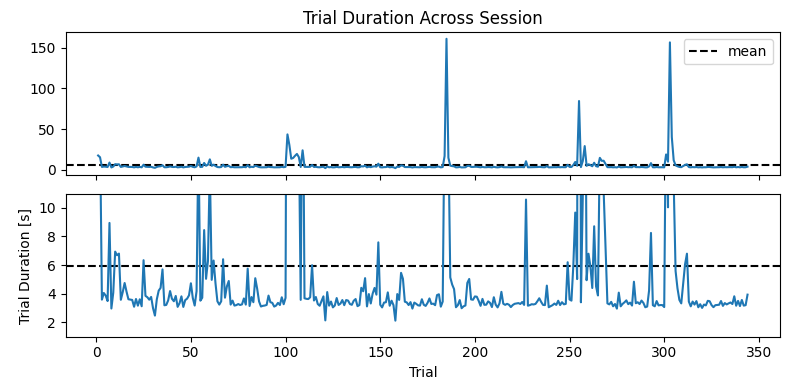

In [14]:
fig,axs = plt.subplots(2,1, figsize=(8,4), sharex=True)

plot_single_date_trial_dur(df, date=pd.Timestamp(2022,11,20) , axs=axs)

In [24]:
def plot_trial_dur_history(df, ax, latest_date=None, n_days_back=None, **kwargs):

    """
    Function for plotting duration of trial (as measured by state0 enter
    and exits) across a specified group of days.

    params
    -----
    df : data frame
        trials data frame with ['trial', 't_dur', 'date'] columns
    ax : ndarray
        ax to plot to
    latest_date : str or pd_datetime (optional, default = None)
        latest date to include in the window, defaults to
        the latest date in the data frame
    n_days_back : int (optional, default = None)
        number of days back from `latest_date` to include,
        defaults to all days

    *note* see `filter_for_date_window()` for more info 
    *      on df date filtering

    plots
    ----
    ax = line plot with 95% CI + marker for average trial dur 
        for each specified date
    """
    df = filter_for_date_window(df, latest_date=latest_date, n_days_back=n_days_back)
    
    sns.lineplot(data=df, x="date", y="t_dur", marker="o", markersize=8, ax=ax, **kwargs)

    _ = plt.xticks(rotation=45)
    _ = ax.set(ylabel="Trail Duration [s]")
    sns.despine()


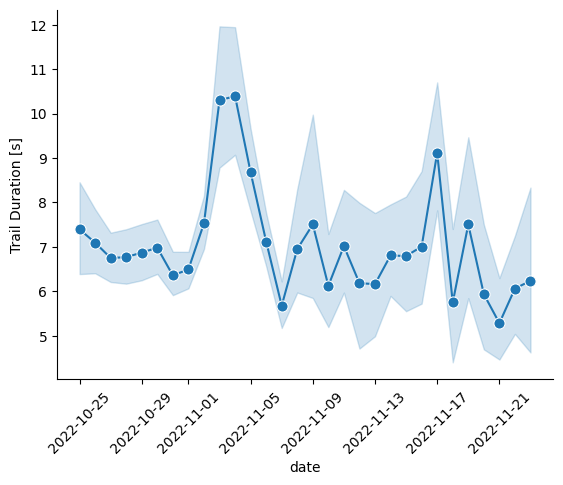

In [22]:
fig, ax = plt.subplots()
plot_trial_dur_history(df, ax=ax, latest_date=None, n_days_back=30)

In [3]:

# #### SINGLE SESSION ####
# session_key = {'sessid': 884257}

# prb = (bdata.Sessions & session_key).fetch(
#     "protocol_data", as_dict=True
# )

# s_id, d, t = (bdata.Sessions & session_key).fetch(
#     "sessid", "sessiondate", "n_done_trials"
# )
# prd = convert_to_dict(prb)
# pd_prepare_dict_for_df(prd)
# session_key = {'sessid': s_id[0]}
# pehb = (bdata.ParsedEvents & session_key).fetch("peh", as_dict=True)
# pehd = bt.transform_blob(pehb[0]['peh'])

